In [1]:
import os
PATH_TO_REPO = '/code/MultiCapCLIP'
os.chdir(PATH_TO_REPO)

In [2]:
import configs
from models import build_model
import torch
from datasets import create_dataset
import numpy as np
import random
import torch.backends.cudnn as cudnn


class Args(object):
    def __init__(self, **kwargs):
        super().__init__()
        for k, v in kwargs.items():
            setattr(self, k, v)
            

def standardize(data: torch.Tensor):
    return (data - data.mean(dim=0, keepdim=True)) / data.std(dim=0, keepdim=True)


def run(path, dataset, n_samples = 200, noise_std=0, N=0, seed=42, mode='train'):
    args = Args(**dict(
        from_pretrained=path,
        dataset=dataset,
        method=None,
        pickle=True,
    ))
    
    if noise_std > 0 or N > 0:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.benchmark = True
    
    config = configs.create_config(args, mode='finetune')
    print(config)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_model(config, mode='finetune')
    checkpoint_path = os.path.join(path, f'{dataset}_best.pth')
    checkpoint = torch.load(checkpoint_path, 'cpu')
    epoch = checkpoint['epoch']
    msg = model.load_pretrained_state_dict(checkpoint['model'])
    model = model.to(device)

    if config.get('concepts', False):
        model.concept_prompts = model.prepare_concept_prompts(model.concepts_path)
    
    train_dataset, val_dataset, test_dataset = create_dataset(config, mode='finetune', preprocess=model.preprocess)

    if mode == 'train':
        loader = iter(train_dataset)
    else:
        loader = iter(test_dataset)
    
    if N > 0:
        assert mode == 'train'
        related_caption_ids_path = os.path.join(configs.related_caption_ids_root, config['clip_arch'].lower().replace('/', '-'), f'{args.dataset}.txt')
        data = open(related_caption_ids_path, 'r').read().strip().split('\n')
        related_caption_ids = [
            list(map(lambda x: int(x), item.split(','))) 
            for item in data
        ]
        assert len(train_dataset) == len(related_caption_ids)
        captions = [item['caption'] for item in loader]
        loader = iter(train_dataset)

    model.eval()
    image_feats = []
    text_feats = []
    image_id = None
    i = -1
    with torch.no_grad():
        while True:
            item = next(loader)
            if item['image_id'] == image_id:
                continue
            else:
                image_id = item['image_id']

            i += 1
            if i >= n_samples:
                break

            if N > 0:
                idx = random.choice(related_caption_ids[i][:N])
                raw_caption = captions[idx]
            else:
                raw_caption = item['caption'][0] if isinstance(item['caption'], list) else item['caption']
            clip_text_embs, *_ = model.get_clip_text_embs(raw_text=raw_caption)
            if noise_std != 0:
                noise = torch.randn(clip_text_embs.shape).to(device) * noise_std
                clip_text_embs = torch.nn.functional.normalize(clip_text_embs + noise, dim=-1)
            clip_text_embs, *_ = model.clip_projecter(clip_text_embs, 'text', concept_prompts=model.concept_prompts)
            text_feats.append(clip_text_embs.mean(1))

            clip_image_embs = torch.FloatTensor(item['clip_image_embs'])[None, :].to(device)
            clip_image_embs = model.get_clip_image_embs(clip_image_embs=clip_image_embs)
            clip_image_feats, *_ = model.clip_projecter(clip_image_embs, 'image', concept_prompts=model.concept_prompts)
            image_feats.append(clip_image_feats.mean(1))

    image_feats = torch.cat(image_feats, dim=0)
    text_feats = torch.cat(text_feats, dim=0)
    
    return image_feats, text_feats

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_samples = 200
image_feats1, text_feats1 = run('output/adapt/vit-b-16_coco_baseline', 'coco', n_samples, mode='train')

{'add_cross_attention': True, 'normalize': True, 'method': 'baseline'}
{'clip_arch': 'ViT-B/16', 'clip_root': 'data/checkpoints', 'text_model': 'data/checkpoints/bert-base-uncased', 'decoder_config': 'configs/L6_H8_D512.json', 'init_with_bert': False, 'label_smoothing': 0.1, 'batch_size_train': 32, 'batch_size_test': 32, 'num_workers': 4, 'max_tokens': 40, 'max_length': 20, 'min_length': 5, 'num_beams': 3, 'prompt': '', 'optimizer': {'opt': 'adamW', 'lr': 0.0001, 'weight_decay': 0.01, 'lr_mult': 1}, 'schedular': {'sched': 'fix', 'lr': 0.0001, 'epochs': 10, 'num_warmup_steps': 0.1}, 'start_eval': 0, 'train_langs': ['en'], 'eval_lang': 'en', 'train_en_prob': None, 'add_cross_attention': True, 'normalize': True, 'method': 'baseline', 'dataset': 'coco', 'train_file': 'data/annotations/coco/en/train.json', 'val_file': 'data/annotations/coco/en/val.json', 'test_file': 'data/annotations/coco/en/test.json', 'val_gt_file': 'data/annotations/coco/en/val_gt.json', 'test_gt_file': 'data/annotation

In [4]:
image_feats2, text_feats2 = run('output/adapt/vit-b-16_coco_MultiCapCLIP_01', 'coco', n_samples, N=5, noise_std=0.1, mode='train')

{'add_cross_attention': True, 'normalize': True, 'method': 'MultiCapCLIP_01', 'concepts': True, 'n_concept_prompts': 16, 'ConceptPromptPrefixer': True, 'exclude_from_visual_features': True, 'concept_fn': 'concepts.txt', 'with_related_caption_as_input': True, 'related_caption_topk': 5, 'noise_std': 0.1}
{'clip_arch': 'ViT-B/16', 'clip_root': 'data/checkpoints', 'text_model': 'data/checkpoints/bert-base-uncased', 'decoder_config': 'configs/L6_H8_D512.json', 'init_with_bert': False, 'label_smoothing': 0.1, 'batch_size_train': 32, 'batch_size_test': 32, 'num_workers': 4, 'max_tokens': 40, 'max_length': 20, 'min_length': 5, 'num_beams': 3, 'prompt': '', 'optimizer': {'opt': 'adamW', 'lr': 0.0001, 'weight_decay': 0.01, 'lr_mult': 1}, 'schedular': {'sched': 'fix', 'lr': 0.0001, 'epochs': 10, 'num_warmup_steps': 0.1}, 'start_eval': 0, 'train_langs': ['en'], 'eval_lang': 'en', 'train_en_prob': None, 'add_cross_attention': True, 'normalize': True, 'method': 'MultiCapCLIP_01', 'concepts': True, '

In [5]:
from sklearn import manifold

feats1 = torch.cat((image_feats1, text_feats1), dim=0)
feats2 = torch.cat((image_feats2, text_feats2), dim=0)
print(feats1.shape, feats2.shape)

random_state = 42

pca = manifold.TSNE(n_components=2, random_state=random_state)
transformed_feats1 = pca.fit_transform(feats1.cpu().numpy())

pca = manifold.TSNE(n_components=2, random_state=random_state)
transformed_feats2 = pca.fit_transform(feats2.cpu().numpy())

torch.Size([400, 512]) torch.Size([400, 512])


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Our re-produced output

torch.Size([400, 512]) torch.Size([400, 512]) 200
(400, 2) (400, 2)


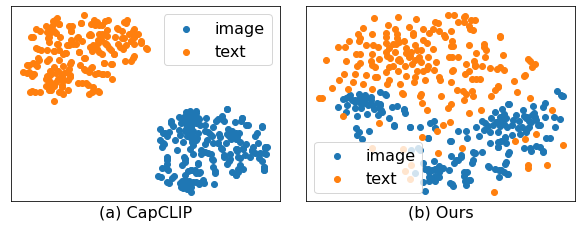

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

print(feats1.shape, feats2.shape, n_samples)
print(transformed_feats1.shape, transformed_feats2.shape)

fig = plt.figure(figsize=(8, 3))

fs = 16

ax = plt.subplot(121)
ax.scatter(transformed_feats1[:n_samples, 0], transformed_feats1[:n_samples, 1], label='image')
ax.scatter(transformed_feats1[n_samples:, 0], transformed_feats1[n_samples:, 1], label='text')
ax.legend(fontsize=fs)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('(a) CapCLIP', fontdict={'fontsize': fs})

ax = plt.subplot(122)
ax.scatter(transformed_feats2[:n_samples, 0], transformed_feats2[:n_samples, 1], label='image')
ax.scatter(transformed_feats2[n_samples:, 0], transformed_feats2[n_samples:, 1], label='text')
ax.legend(fontsize=fs)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('(b) Ours', fontdict={'fontsize': fs})

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.09, top=0.99, wspace=0.1)
# plt.savefig('ablation_tsne.png', dpi=300)

# Our original output

torch.Size([400, 512]) torch.Size([400, 512]) 200
(400, 2) (400, 2)


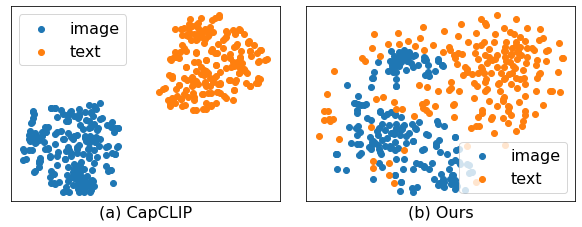

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt

print(feats1.shape, feats2.shape, n_samples)
print(transformed_feats1.shape, transformed_feats2.shape)

fig = plt.figure(figsize=(8, 3))

fs = 16

ax = plt.subplot(121)
ax.scatter(transformed_feats1[:n_samples, 0], transformed_feats1[:n_samples, 1], label='image')
ax.scatter(transformed_feats1[n_samples:, 0], transformed_feats1[n_samples:, 1], label='text')
ax.legend(fontsize=fs)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('(a) CapCLIP', fontdict={'fontsize': fs})

ax = plt.subplot(122)
ax.scatter(transformed_feats2[:n_samples, 0], transformed_feats2[:n_samples, 1], label='image')
ax.scatter(transformed_feats2[n_samples:, 0], transformed_feats2[n_samples:, 1], label='text')
ax.legend(fontsize=fs)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('(b) Ours', fontdict={'fontsize': fs})

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.09, top=0.99, wspace=0.1)
plt.savefig('ablation_tsne.png', dpi=300)